#Image Data


Shape of X_train: (60000, 1, 28, 28)
New Shape of X_train: (60000, 28, 28)


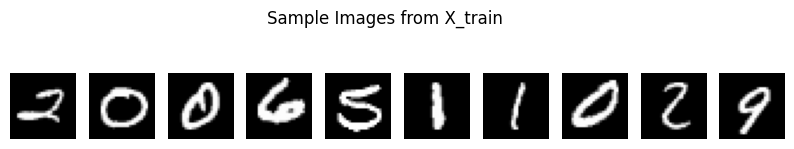

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the image data
X_train = np.load('unlabelled_train_data_images.npy')  # Shape expected: (num_samples, height, width)

# Print shape and show a few sample images
print("Shape of X_train:", X_train.shape)
X_train = X_train.squeeze()

print("New Shape of X_train:", X_train.shape)

# Visualize 10 random samples
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.axis('off')
plt.suptitle("Sample Images from X_train")
plt.show()



Basic EDA:
Data type: float32
Number of images: 60000
Image dimensions: 28x28
Number of channels: 1

Pixel Value Distribution (first image):


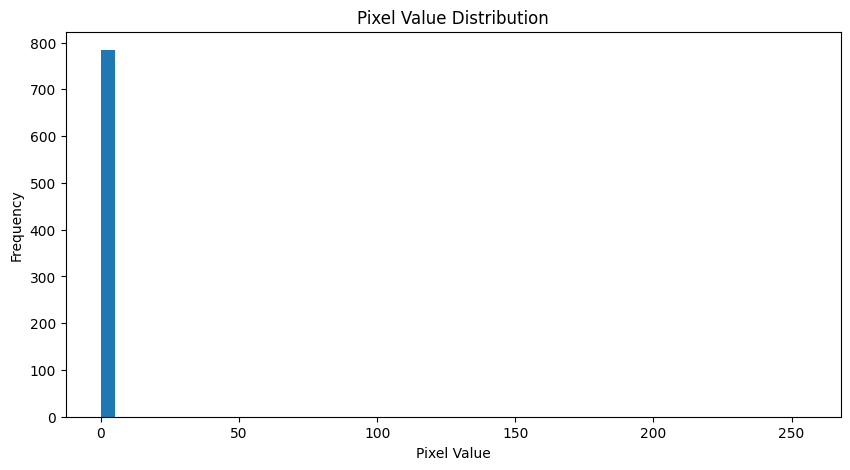


Overall Pixel Statistics:
Mean pixel value: 0.13
Standard deviation of pixel values: 0.31


In [ ]:
print("\nBasic EDA:")
print(f"Data type: {X_train.dtype}")
# Number of samples
num_samples = X_train.shape[0]
print(f"Number of images: {num_samples}")

# Dimensions of each image
image_height, image_width = X_train.shape[1], X_train.shape[2]
num_channels = X_train.shape[3] if X_train.ndim == 4 else 1
print(f"Image dimensions: {image_height}x{image_width}")
print(f"Number of channels: {num_channels}")

# Distribution of pixel values (can be computationally expensive for large datasets)
print("\nPixel Value Distribution (first image):")
if num_samples > 0:
    plt.figure(figsize=(10, 5))
    if num_channels == 1:
        plt.hist(X_train[0].flatten(), bins=50, range=(0, 255)) # Assuming 0-255 range
    else:
        # Plot histograms for each channel
        for c in range(num_channels):
            plt.hist(X_train[0, :, :, c].flatten(), bins=50, range=(0, 255), alpha=0.7, label=f'Channel {c}')
        plt.legend()
    plt.title('Pixel Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()
# Calculate basic statistics (mean, std deviation) of pixel values across all images
print("\nOverall Pixel Statistics:")
mean_pixel = np.mean(X_train)
std_pixel = np.std(X_train)
print(f"Mean pixel value: {mean_pixel:.2f}")
print(f"Standard deviation of pixel values: {std_pixel:.2f}")

Flattens each image (e.g., 28×28) into a single row vector (784-dimensional).

Simple baseline representation that can be used with clustering or classifiers.

In [ ]:
# Flatten each image into a 1D vector
num_samples = X_train.shape[0]
flattened_X = X_train.reshape(num_samples, -1)  # shape: (num_samples, height * width)

print("Shape after flattening:", flattened_X.shape)

Shape after flattening: (60000, 784)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
flattened_X_scaled = scaler.fit_transform(flattened_X)

print("Shape after standardization:", flattened_X_scaled.shape)


Shape after standardization: (60000, 784)


PCA compresses high-dimensional flattened vectors into a 90% Dimention representation.

Helps improve clustering quality by denoising and reducing redundancy.


In [ ]:
from sklearn.decomposition import PCA

# Reduce components to catureing 90% of the variance for better clustering
pca = PCA(n_components=0.90, random_state=42)
X_pca = pca.fit_transform(flattened_X)

print("Shape after PCA:", X_pca.shape)


Shape after PCA: (60000, 87)


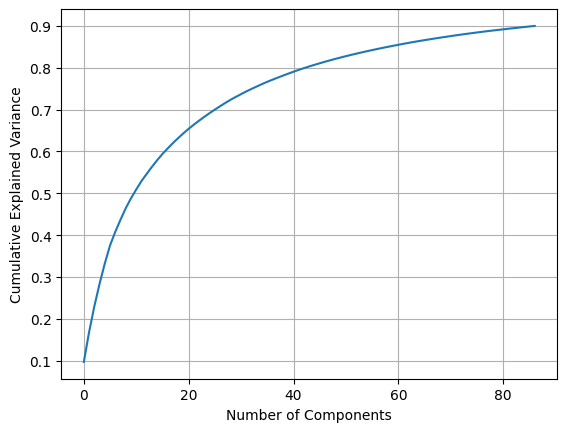

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()


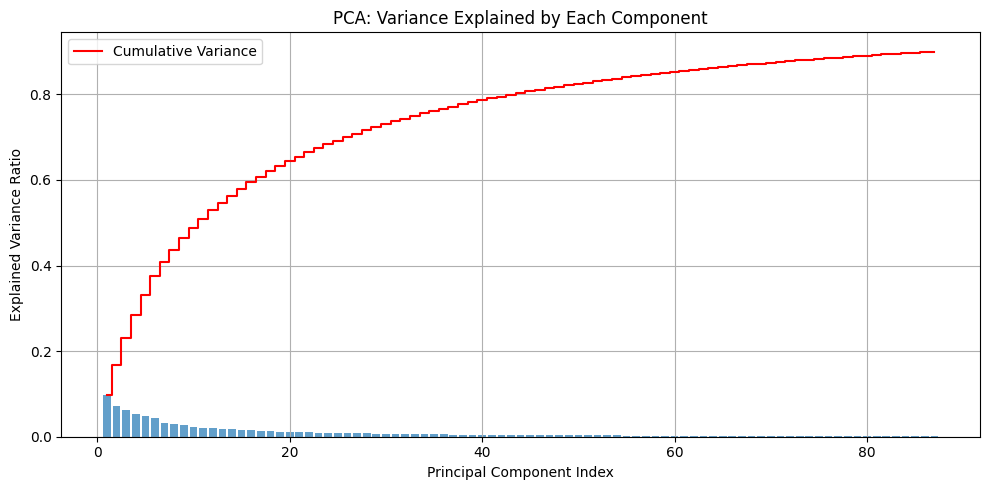

In [ ]:
# Explained variance for each component
explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.7, align='center')
plt.step(range(1, len(explained_var) + 1), np.cumsum(explained_var), where='mid', color='red', label='Cumulative Variance')

plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA: Variance Explained by Each Component')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

##Clustering on PCA Features
- KMeans Clustering

Applies KMeans on the 87D PCA features.

Assigns a pseudo-label (0–9) to each image.

Visualizes the number of samples in each cluster to check balance.

Assigned labels shape: (60000,)


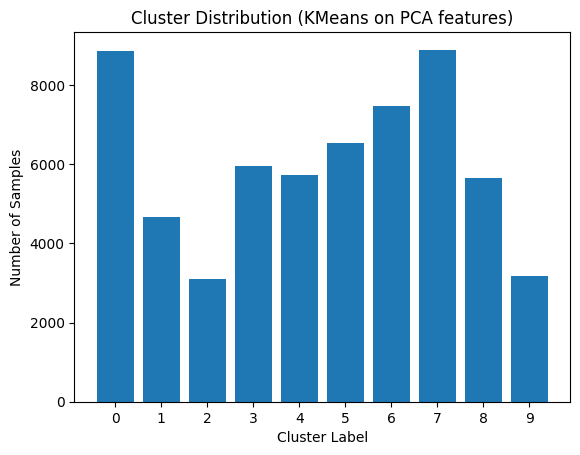

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Cluster into 10 clusters (since we expect digits 0-9)
#kmeans_pca = KMeans(n_clusters=10, random_state=42)
kmeans_pca = KMeans(n_clusters=10, init='k-means++', n_init=30, random_state=42)

Y_pca_kmeans = kmeans_pca.fit_predict(X_pca)

print("Assigned labels shape:", Y_pca_kmeans.shape)

# Plot cluster distribution
plt.hist(Y_pca_kmeans, bins=np.arange(11)-0.5, rwidth=0.8)
plt.xticks(range(10))
plt.xlabel("Cluster Label")
plt.ylabel("Number of Samples")
plt.title("Cluster Distribution (KMeans on PCA features)")
plt.show()


t-SNE Visualization of Clusters

Silhouette Score: 0.0725


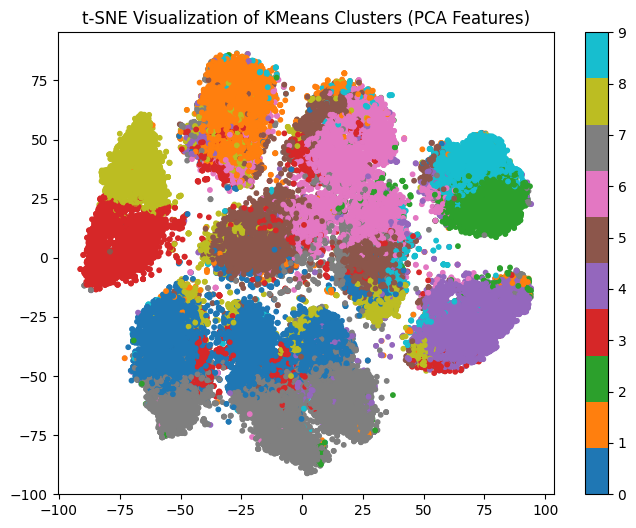

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=70, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

score = silhouette_score(X_pca, Y_pca_kmeans)
print(f"Silhouette Score: {score:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y_pca_kmeans, cmap='tab10', s=10)
plt.title("t-SNE Visualization of KMeans Clusters (PCA Features)")
plt.colorbar()
plt.show()

t-SNE plot shows clear, well-separated clusters, but K-Means isn’t labeling them correctly.

##2D Convolution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# --- 1. Load image data ---
X_train = np.load('unlabelled_train_data_images.npy')  # shape: (num_samples, height, width)
X_train = X_train.squeeze()

In [ ]:
# --- 2. Define 2D convolution function ---
def conv2d(image, kernel, stride=1, padding=0):
    if padding > 0:
        image = np.pad(image, pad_width=((padding, padding), (padding, padding)), mode='constant')
    H, W = image.shape
    kH, kW = kernel.shape
    out_height = (H - kH) // stride + 1
    out_width = (W - kW) // stride + 1
    output = np.zeros((out_height, out_width))
    for y in range(out_height):
        for x in range(out_width):
            region = image[y*stride:y*stride+kH, x*stride:x*stride+kW]
            output[y, x] = np.sum(region * kernel)
    return output

    # --- 3. Define a set of basic kernels ---
kernels = {
    'sobel_x': np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
    'sobel_y': np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
    'laplacian': np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]),
    'sharpen': np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]),
    'gaussian_3x3': (1/16) * np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]])
}

In [ ]:
# --- 4. Apply convolution and extract features ---
features = []
for img in X_train:
    img_features = []
    for name, kernel in kernels.items():
        conv = conv2d(img, kernel, stride=1, padding=1)
        img_features.append(np.mean(conv))
        img_features.append(np.std(conv))
    features.append(img_features)

features = np.array(features)  # shape: (num_samples, num_kernels * 2)

In [ ]:
features.shape

(60000, 10)

In [ ]:
features[0]

array([0.        , 0.71129462, 0.        , 1.25429711, 0.        ,
       0.38865367, 0.10692777, 0.60284771, 0.10692777, 0.22760286])

In [ ]:
# --- 5. Standardize features ---
features_stand = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

Shape after PCA: (60000, 2)


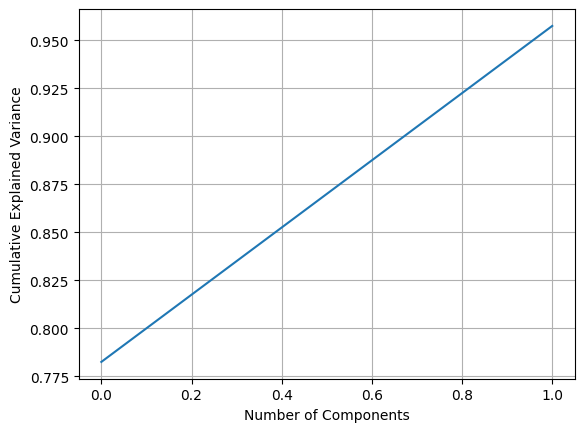

In [ ]:
# --- 6. PCA for dimensionality reduction ---
pca = PCA(n_components=.9)  # Small components to visualize
X_pca = pca.fit_transform(features)

print("Shape after PCA:", X_pca.shape)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

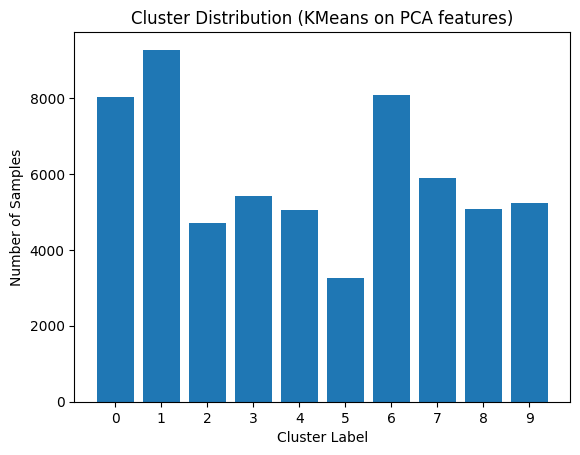

In [ ]:
# --- 7. Clustering with KMeans ---
kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(X_pca)

# Plot cluster distribution
plt.hist(labels, bins=np.arange(11)-0.5, rwidth=0.8)
plt.xticks(range(10))
plt.xlabel("Cluster Label")
plt.ylabel("Number of Samples")
plt.title("Cluster Distribution (KMeans on PCA features)")
plt.show()

In [ ]:
# --- 8. Evaluation ---
score = silhouette_score(X_pca, labels)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.3373


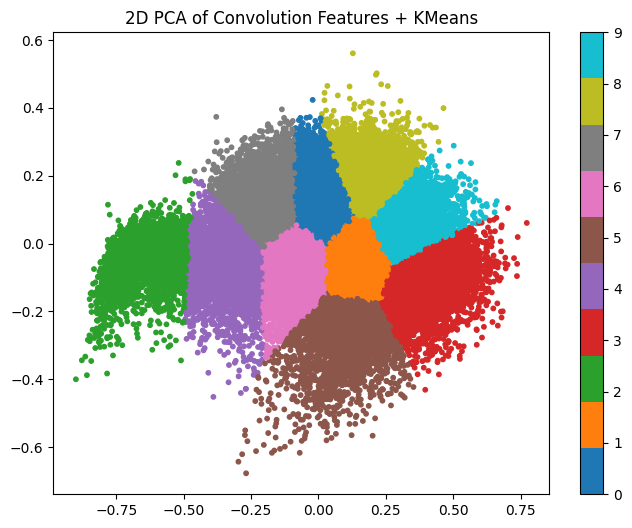

In [ ]:
# --- 9. Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=10)
plt.title("2D PCA of Convolution Features + KMeans")
plt.colorbar()
plt.show()

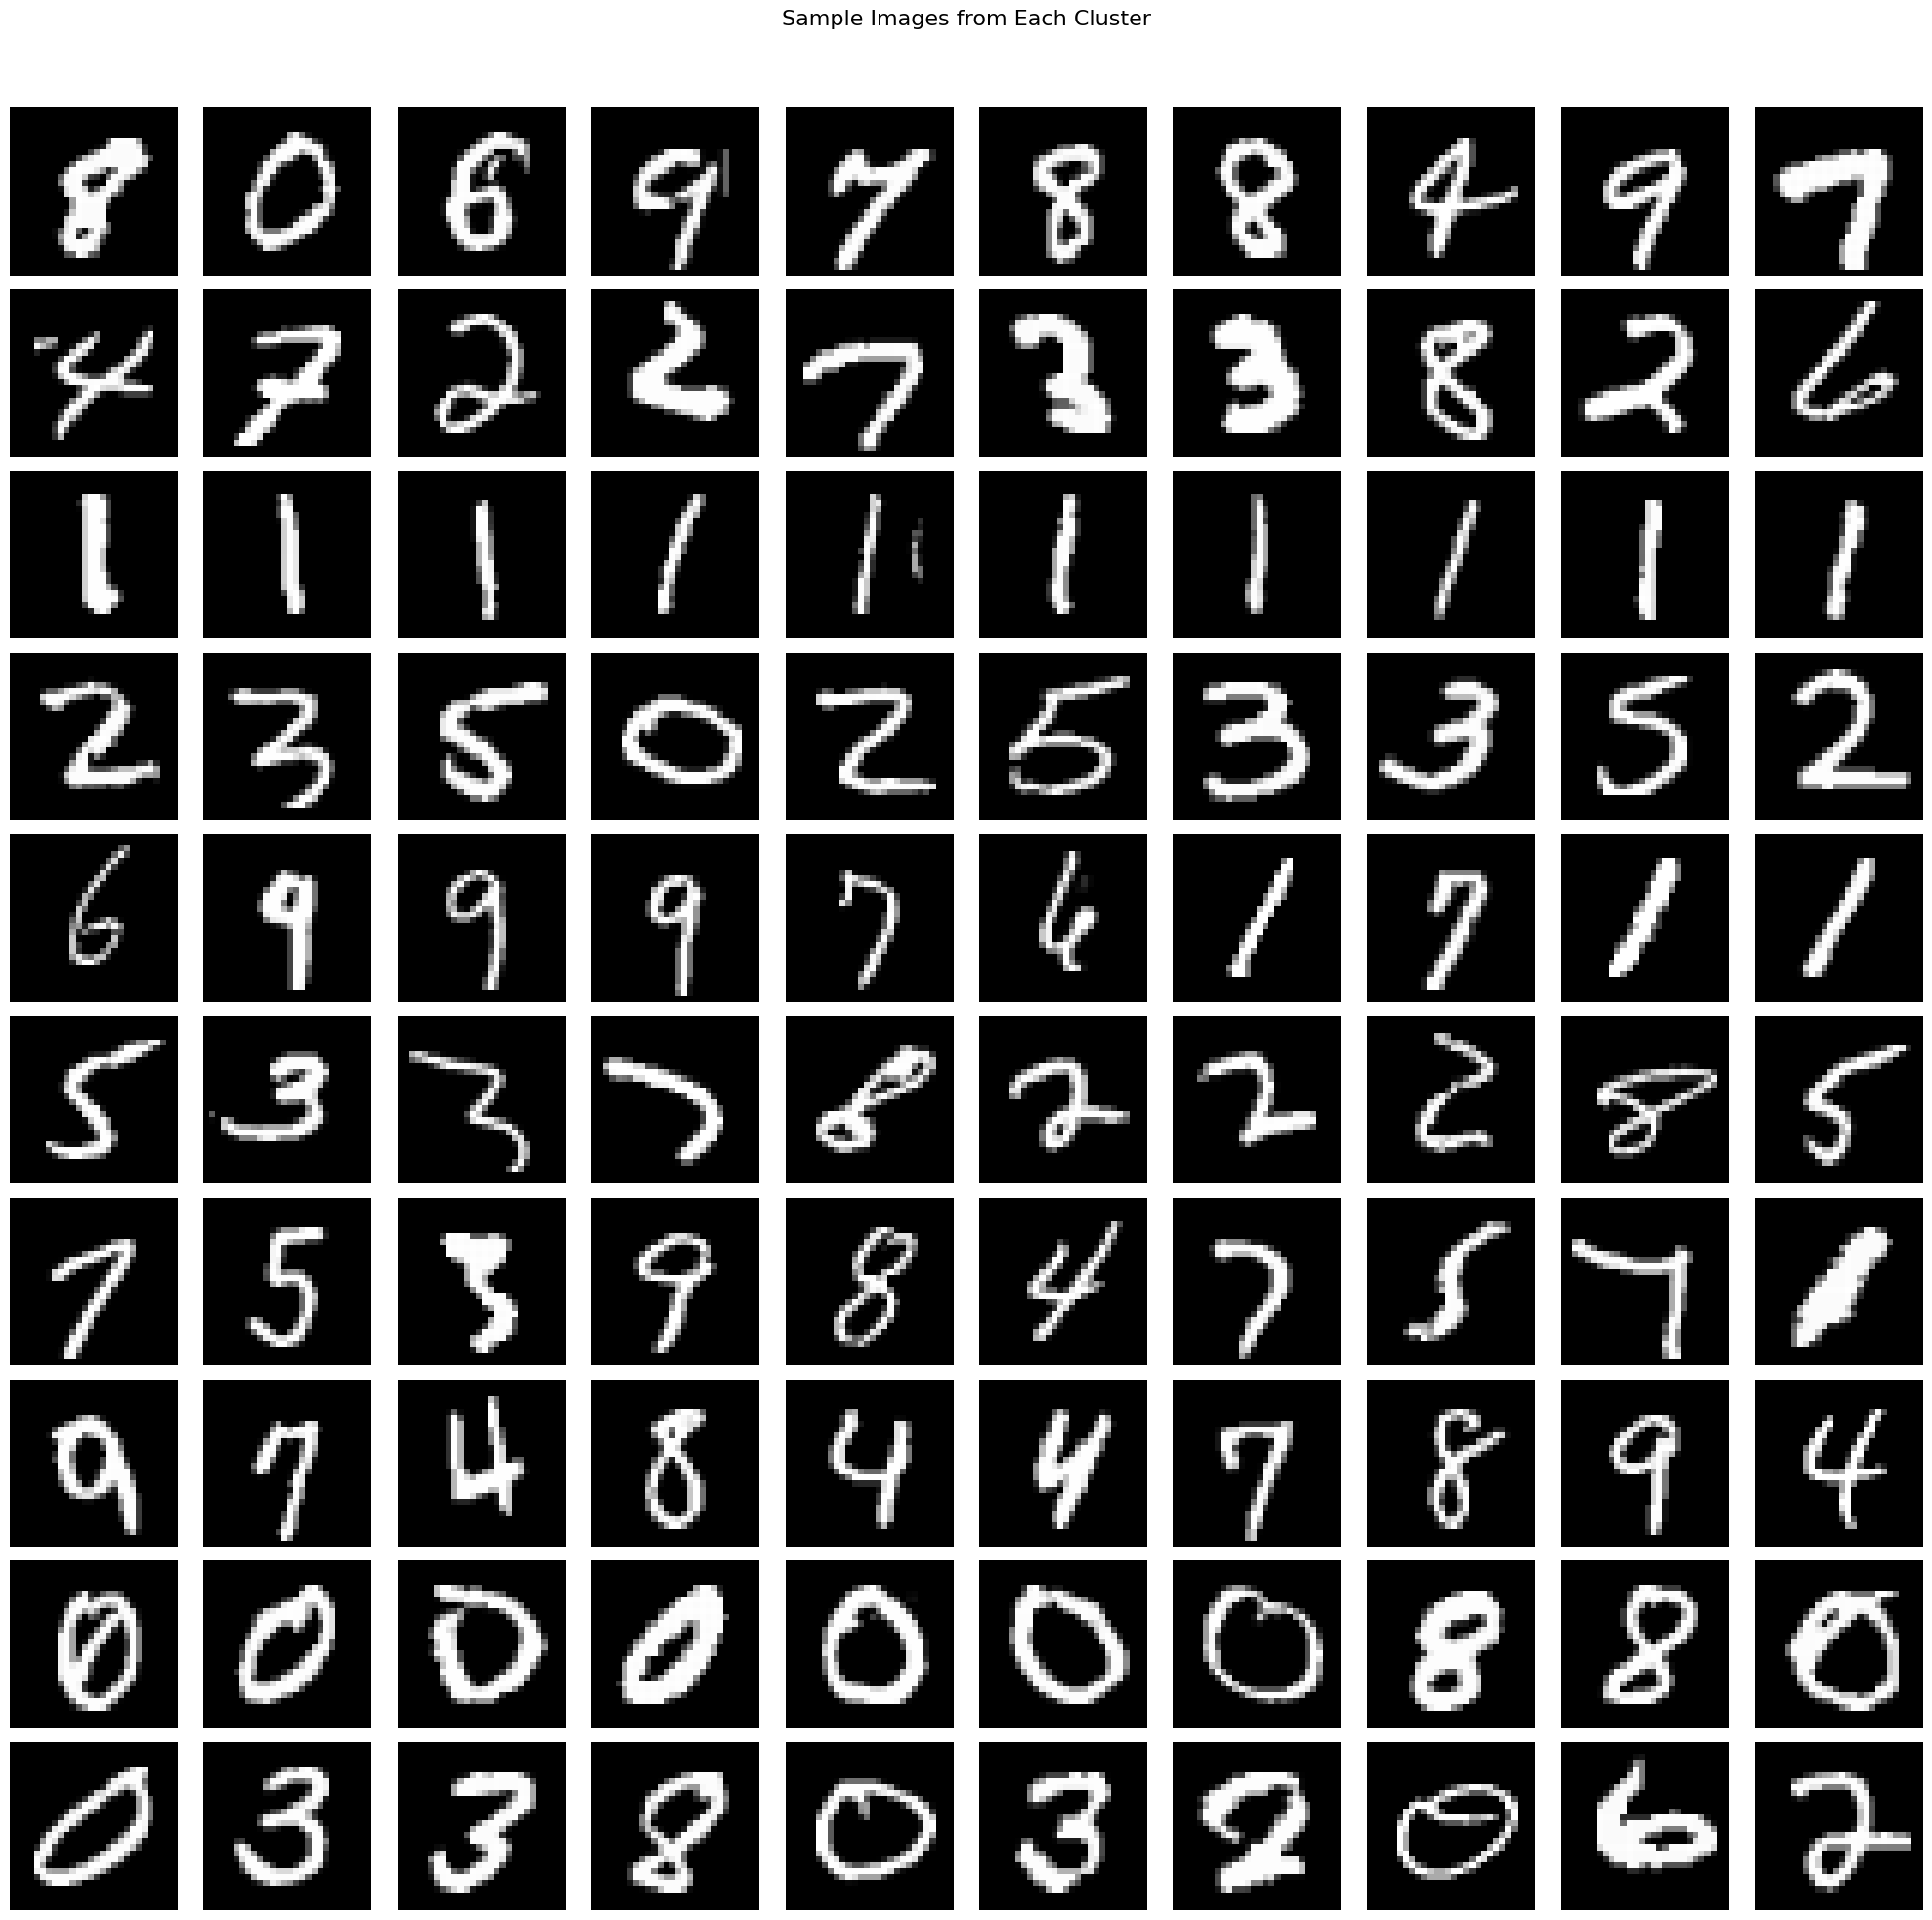

In [ ]:
import matplotlib.pyplot as plt

# Set number of samples to show per cluster
samples_per_cluster = 10
unique_labels = np.unique(labels)

plt.figure(figsize=(samples_per_cluster * 2, len(unique_labels) * 2))

for cluster_id in unique_labels:
    # Get indices of images in the current cluster
    cluster_indices = np.where(labels == cluster_id)[0]

    # Randomly select a few images from this cluster
    selected_indices = np.random.choice(cluster_indices, size=min(samples_per_cluster, len(cluster_indices)), replace=False)

    for i, idx in enumerate(selected_indices):
        plt_idx = cluster_id * samples_per_cluster + i + 1
        plt.subplot(len(unique_labels), samples_per_cluster, plt_idx)
        plt.imshow(X_train[idx], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.ylabel(f"Cluster {cluster_id}", fontsize=12)

plt.suptitle("Sample Images from Each Cluster", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


##2D Convolution with Maxpooling

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume X_train is already loaded

def conv2d(image, kernel, stride=1, padding=0):
    # Existing convolution function
    if padding > 0:
        image = np.pad(image, pad_width=((padding, padding), (padding, padding)), mode='constant')
    H, W = image.shape
    kH, kW = kernel.shape
    out_height = (H - kH) // stride + 1
    out_width = (W - kW) // stride + 1
    output = np.zeros((out_height, out_width))
    for y in range(out_height):
        for x in range(out_width):
            region = image[y*stride:y*stride+kH, x*stride:x*stride+kW]
            output[y, x] = np.sum(region * kernel)
    return output

def max_pooling(image, pool_size=(2, 2), stride=2):
    # Simple max pooling function
    H, W = image.shape
    pH, pW = pool_size
    sH, sW = (stride, stride)
    out_height = (H - pH) // sH + 1
    out_width = (W - pW) // sW + 1
    output = np.zeros((out_height, out_width))
    for y in range(out_height):
        for x in range(out_width):
            region = image[y*sH:y*sH+pH, x*sW:x*sW+pW]
            output[y, x] = np.max(region)
    return output

# Define a set of basic kernels
kernels = {
    'sobel_x': np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
    'sobel_y': np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
    'laplacian': np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]),
    'sharpen': np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]),
    'gaussian_3x3': (1/16) * np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]])
}

# --- Apply convolutions and pooling to all images ---
features = []
for img in X_train:
    img_features = []
    for name, kernel in kernels.items():
        # Apply convolution
        conv = conv2d(img, kernel, stride=1, padding=1) # Add padding
        # Apply max pooling
        pooled_conv = max_pooling(conv, pool_size=(2, 2), stride=2)
        # Flatten the pooled output and add to features
        img_features.extend(pooled_conv.flatten())
    features.append(img_features)

features = np.array(features)

print("Shape of extracted features after convolution and pooling:", features.shape)

Shape of extracted features after convolution and pooling: (60000, 980)


In [ ]:
features[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.17647061e-02,  1.45098045e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.39215690e-01,
        9.01960790e-01,  1.12941179e+00,  5.25490224e-01,  5.49019605e-01,
       -3.99999987e-01, -

Shape after PCA: (60000, 129)


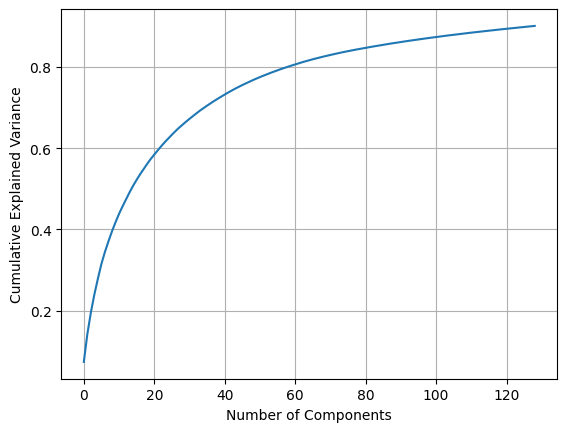

In [ ]:
# --- 5. PCA for dimensionality reduction ---
pca = PCA(n_components=.9)  # Small components to visualize
X_pca = pca.fit_transform(features)

print("Shape after PCA:", X_pca.shape)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

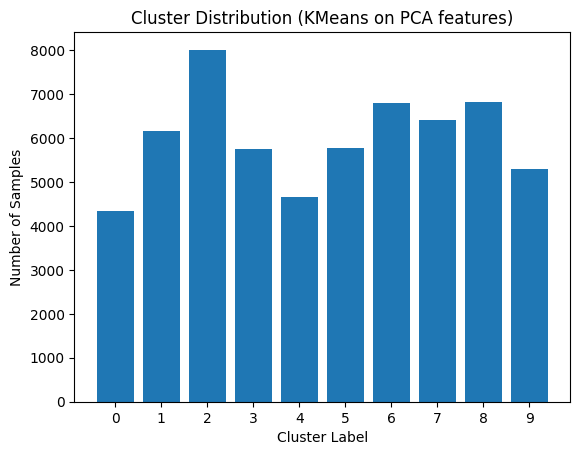

In [ ]:
# --- 6. Clustering with KMeans ---
kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(X_pca)

# Plot cluster distribution
plt.hist(labels, bins=np.arange(11)-0.5, rwidth=0.8)
plt.xticks(range(10))
plt.xlabel("Cluster Label")
plt.ylabel("Number of Samples")
plt.title("Cluster Distribution (KMeans on PCA features)")
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

score = silhouette_score(X_tsne, labels)
print(f"Silhouette Score: {score:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', s=10)
plt.title("t-SNE Visualization of KMeans Clusters (PCA Features)")
plt.colorbar()
plt.show()

KeyboardInterrupt: 

In [ ]:
# --- 7. Evaluation ---
score = silhouette_score(X_pca, labels)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.0792


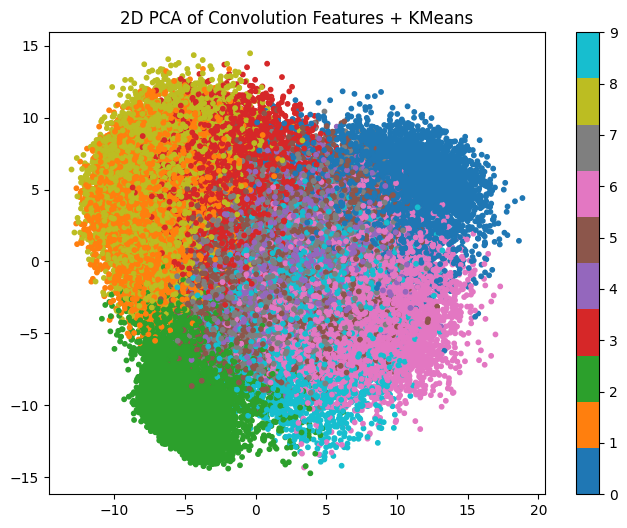

In [ ]:
# --- 9. Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=10)
plt.title("2D PCA of Convolution Features + KMeans")
plt.colorbar()
plt.show()

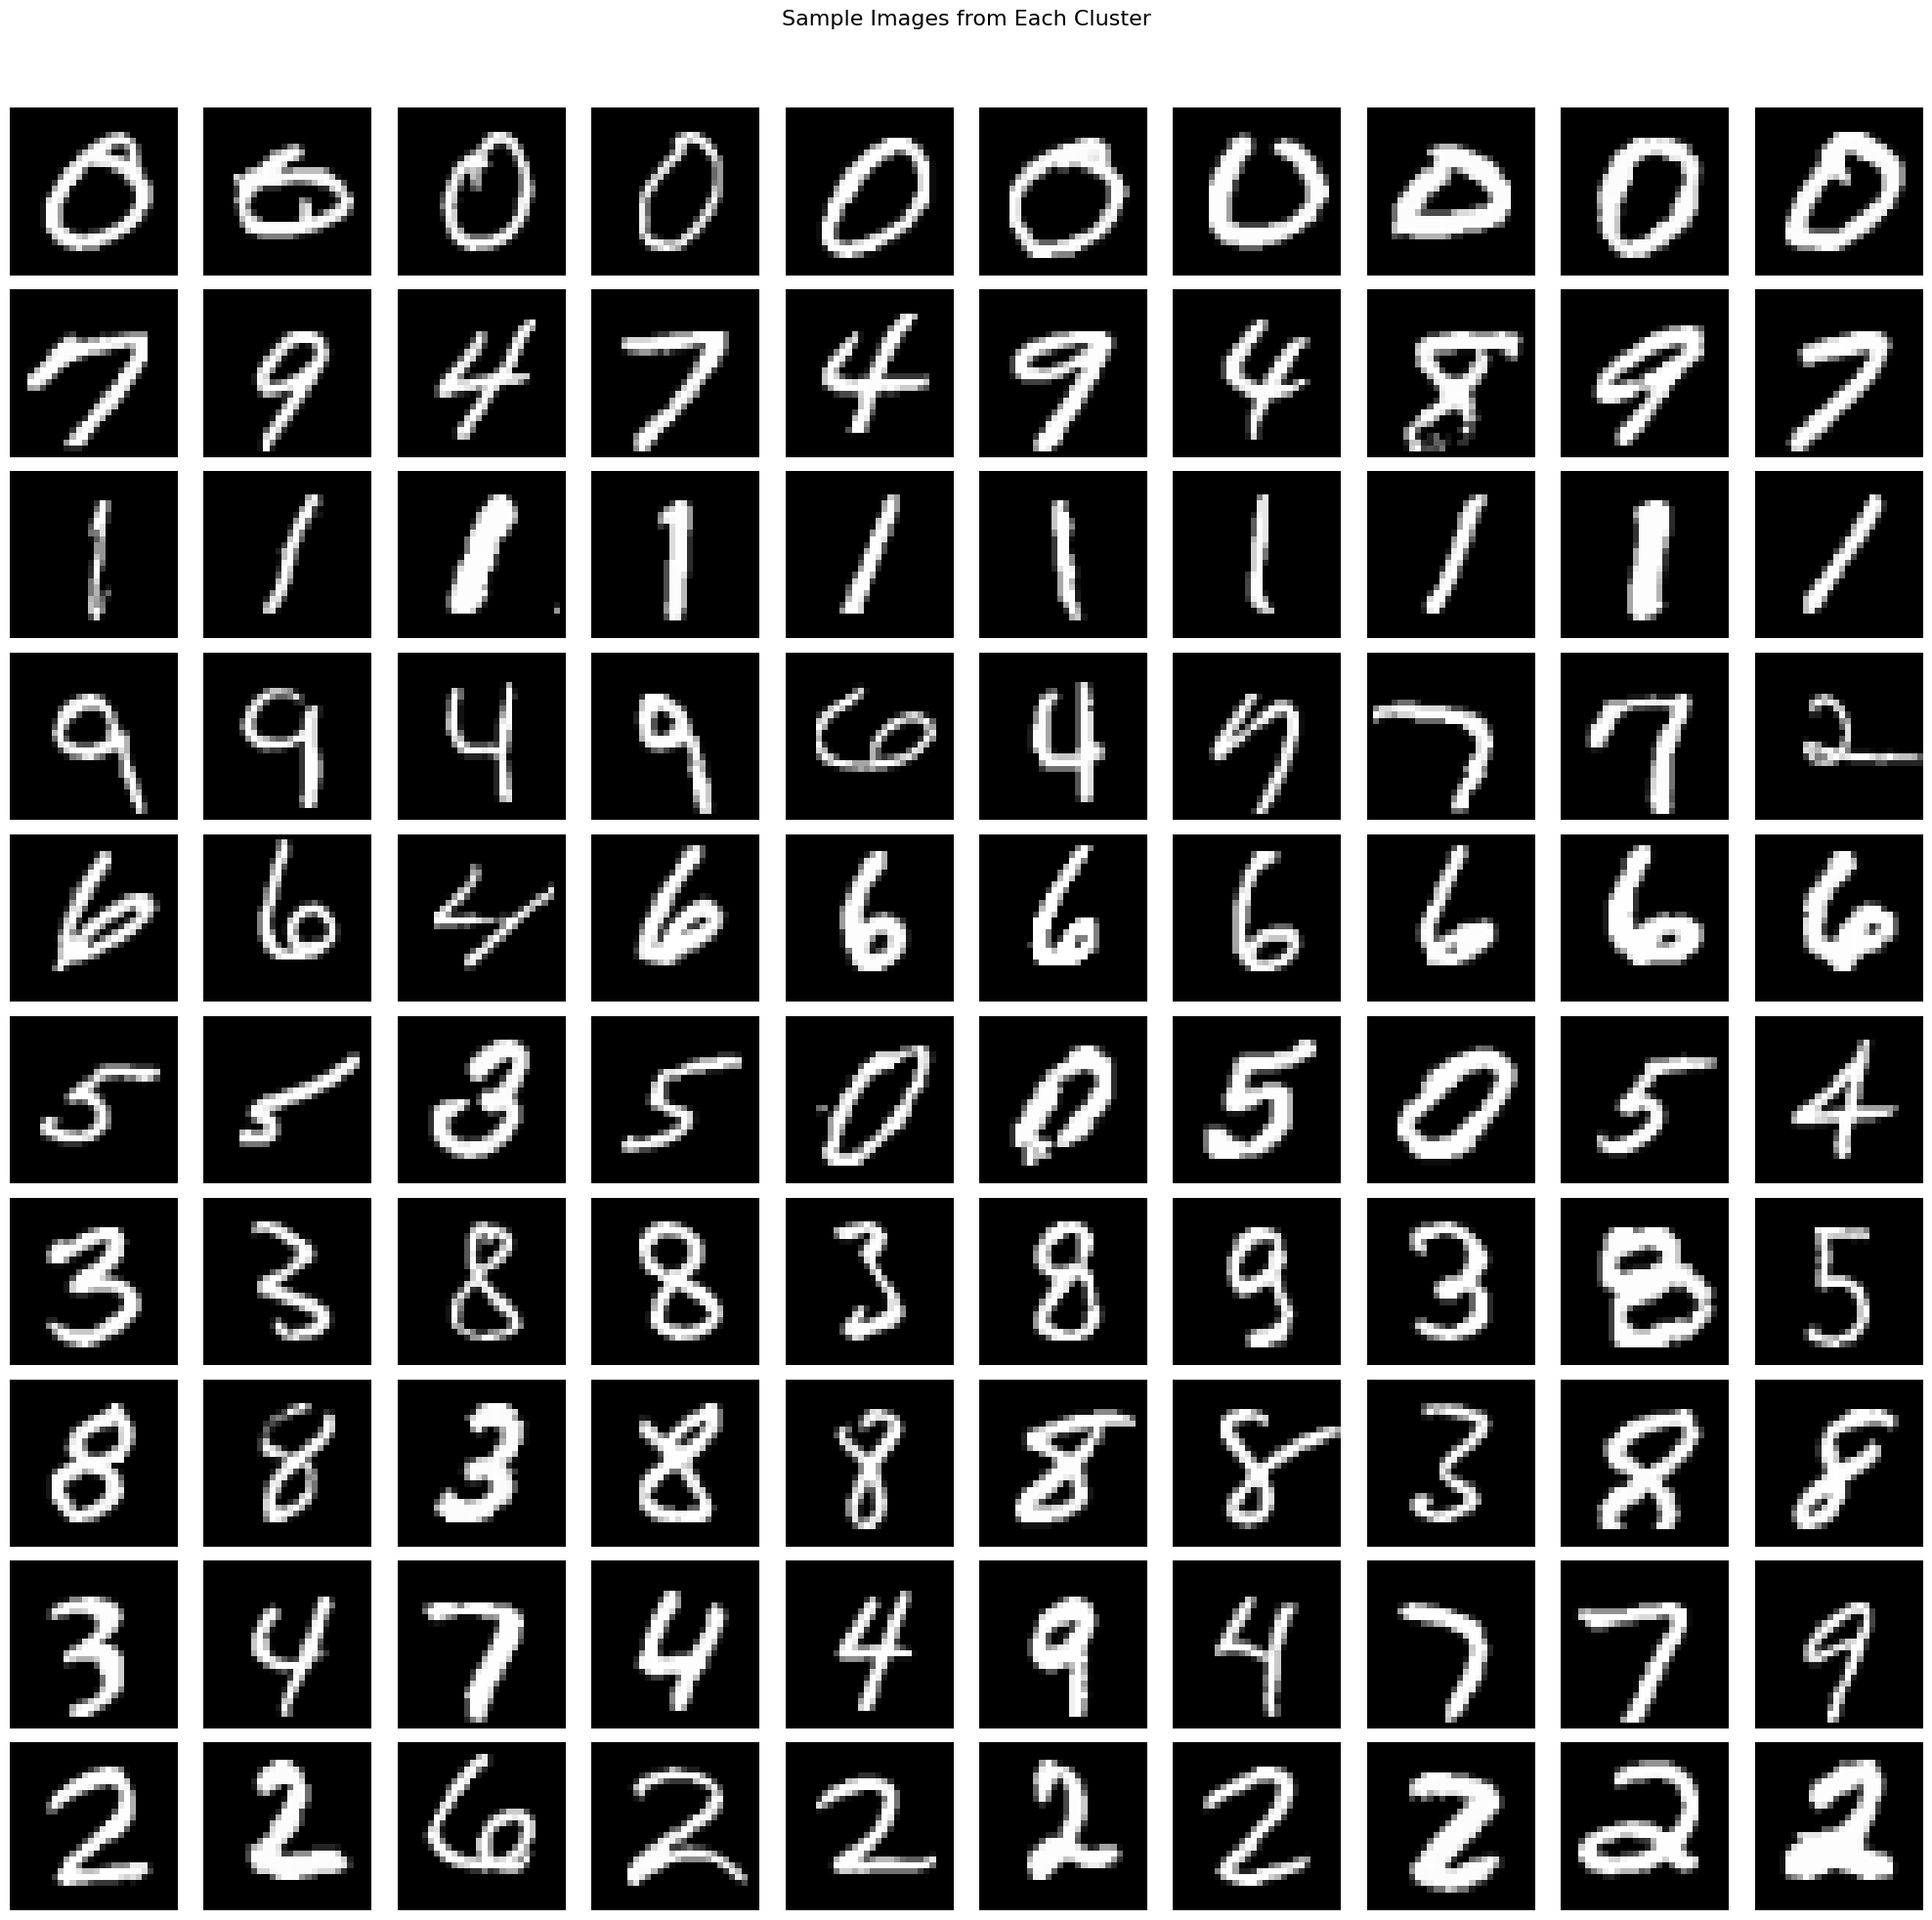

In [ ]:
import matplotlib.pyplot as plt

# Set number of samples to show per cluster
samples_per_cluster = 10
unique_labels = np.unique(labels)

plt.figure(figsize=(samples_per_cluster * 2, len(unique_labels) * 2))

for cluster_id in unique_labels:
    # Get indices of images in the current cluster
    cluster_indices = np.where(labels == cluster_id)[0]

    # Randomly select a few images from this cluster
    selected_indices = np.random.choice(cluster_indices, size=min(samples_per_cluster, len(cluster_indices)), replace=False)

    for i, idx in enumerate(selected_indices):
        plt_idx = cluster_id * samples_per_cluster + i + 1
        plt.subplot(len(unique_labels), samples_per_cluster, plt_idx)
        plt.imshow(X_train[idx], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.ylabel(f"Cluster {cluster_id}", fontsize=12)

plt.suptitle("Sample Images from Each Cluster", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Assuming you have some manually labeled data
# Replace with your actual labeled data loading and preparation
# For demonstration, let's create some dummy labeled data
# In a real scenario, you would load a separate labeled dataset
num_labeled_samples = 1000 # Example: Manually label 1000 samples
# Select a subset of the extracted features and their corresponding cluster labels
X_labeled = features[:num_labeled_samples]
y_manual_labels = np.random.randint(0, 10, num_labeled_samples) # Replace with actual manual labels

# Combine the manual labels and the cluster labels
# For samples that were manually labeled, use the manual label
# For samples that were not manually labeled, use the cluster label
# This is a simple approach; more sophisticated methods exist for combining
# manual and pseudo-labels.
y_combined_labels = Y_pca_kmeans.copy() # Start with pseudo-labels
y_combined_labels[:num_labeled_samples] = y_manual_labels # Overlay with manual labels

# --- Split data into training and testing sets ---
# Use the extracted features and the combined labels
X_train_classifier, X_test_classifier, y_train_classifier, y_test_classifier = train_test_split(
    features, y_combined_labels, test_size=0.2, random_state=42, stratify=y_combined_labels) # Stratify is important for imbalanced classes

# --- Train and evaluate different classifiers ---

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel='linear', random_state=42),
}

results = {}

for name, clf in classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train_classifier, y_train_classifier)
    y_pred = clf.predict(X_test_classifier)
    accuracy = accuracy_score(y_test_classifier, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} Classification Report:\n{classification_report(y_test_classifier, y_pred)}")
    print("-" * 30)

# --- Determine the best classifier ---
best_classifier_name = max(results, key=results.get)
print(f"The best classifier based on accuracy is: {best_classifier_name} with accuracy {results[best_classifier_name]:.4f}")

# You can now use the 'best_classifier_name' to get the corresponding model
best_model = classifiers[best_classifier_name]

Training Logistic Regression...
Logistic Regression Accuracy: 0.9176
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1760
           1       0.89      0.92      0.91       936
           2       0.90      0.89      0.89       627
           3       0.92      0.89      0.90      1189
           4       0.92      0.92      0.92      1148
           5       0.90      0.91      0.91      1298
           6       0.92      0.93      0.93      1493
           7       0.94      0.94      0.94      1771
           8       0.91      0.90      0.90      1134
           9       0.88      0.86      0.87       644

    accuracy                           0.92     12000
   macro avg       0.91      0.91      0.91     12000
weighted avg       0.92      0.92      0.92     12000

------------------------------
Training Random Forest...
Random Forest Accuracy: 0.9043
Random Forest Classification Report:
    

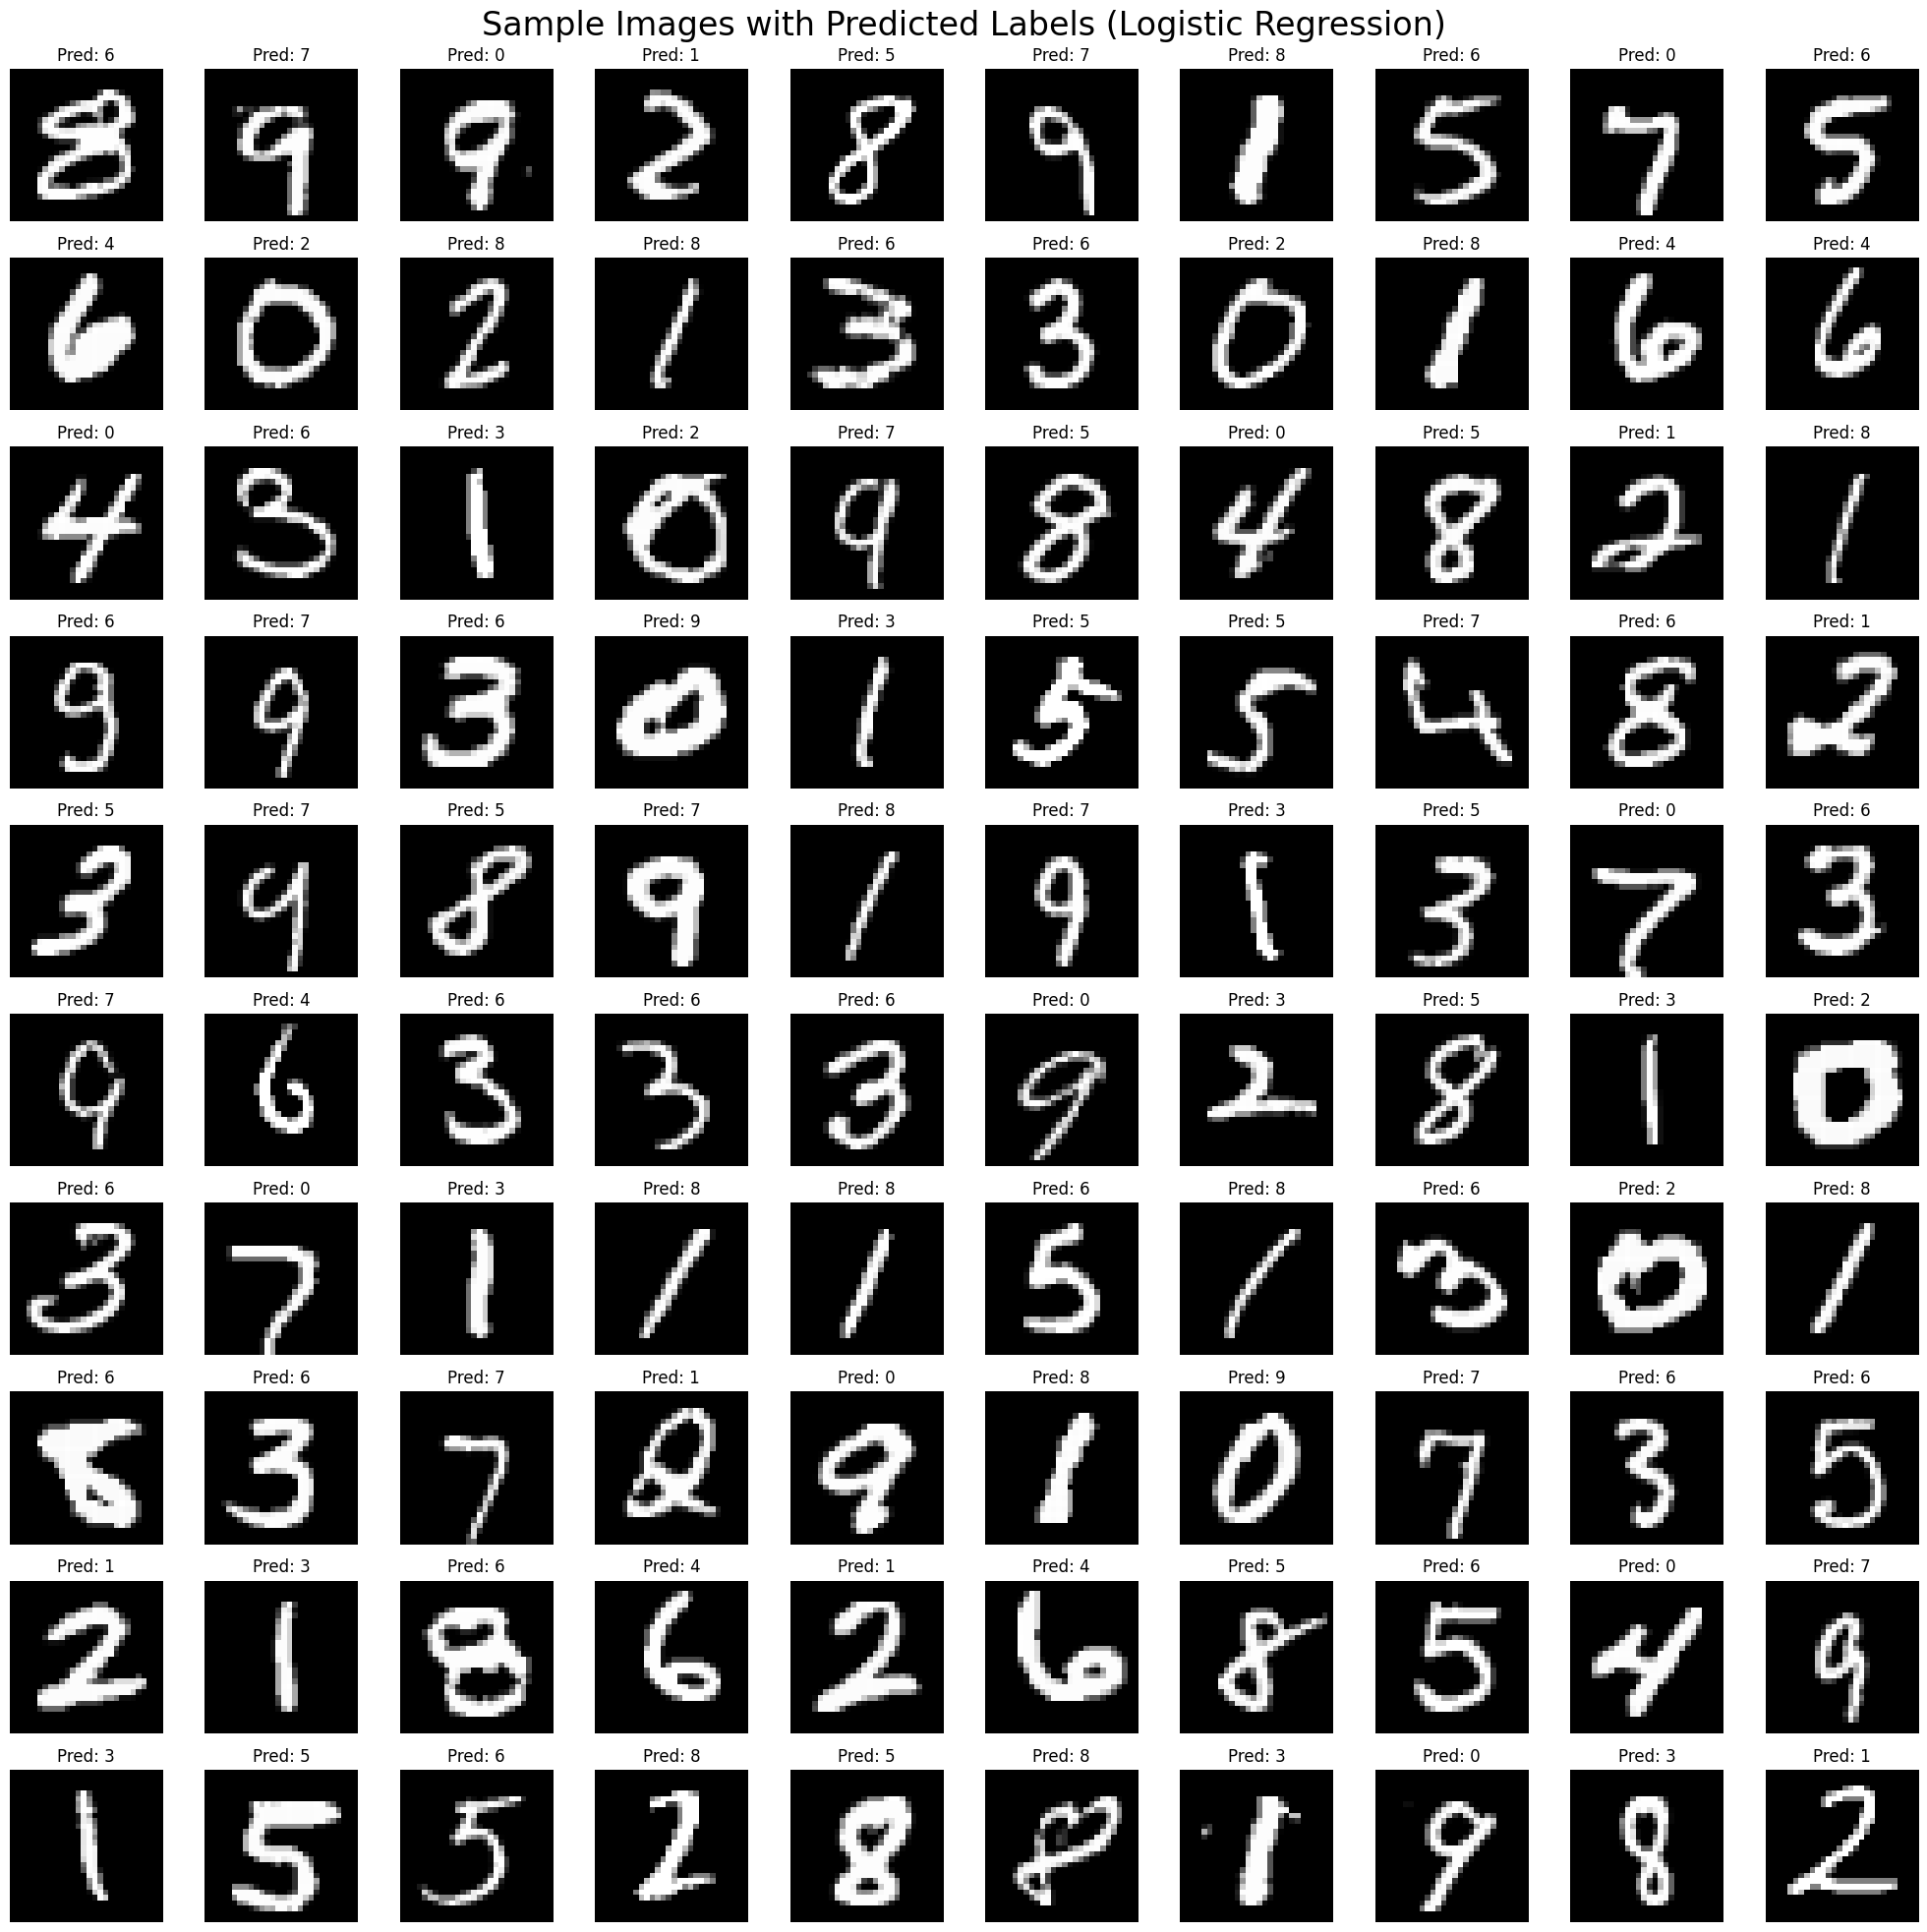

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Predict labels for all samples using the best classifier
predicted_labels = best_model.predict(features)

# Visualize 100 random images with their predicted labels
num_images_to_show = 100
random_indices = np.random.choice(len(X_train), num_images_to_show, replace=False)

plt.figure(figsize=(20, 20)) # Adjust figure size as needed

for i, idx in enumerate(random_indices):
    plt.subplot(10, 10, i + 1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(f"Pred: {predicted_labels[idx]}")
    plt.axis('off')

plt.suptitle(f"Sample Images with Predicted Labels ({best_classifier_name})", fontsize=24)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


The code above performs 2D convolution manually (without TensorFlow or PyTorch) using NumPy, extracts statistical features (mean and standard deviation) from common edge-detection kernels (Sobel, Laplacian, etc.), and clusters the resulting features using PCA and KMeans.